# Correlators of initial chromoelectric and chromomagnetic fields in the non-perturbative Glasma

In this notebook we compute the gauge-invariant field strength correlators for the parameters used in our momentum broadening calculation. We generate Glasma initial conditions and then compute

$
C_E(x_T - y_T) = \big< \mathrm{Tr} \left[ E_z(x_T) U_{x \rightarrow y} E_z(y_T) U_{y \rightarrow x} \right] \big>
$

and similarly for the magnetic field $B_z$.

We compute everthing at fixed $g^2 \mu$ and rescale to fixed $Q_s$ according to the numerical results of  [arXiv:0711.3039](https://arxiv.org/abs/0711.3039).

In [1]:
# Set environment variables 
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["GAUGE_GROUP"] = "su3"
os.environ["PRECISION"] = "double"

# This line is necessary, because cupy otherwise doesn't find
# the cuda installation path. This is probably a configuration
# issue and should be removed on other machines.
os.environ["CUDA_PATH"] = "/usr/local/cuda-9.0"

# Import curraun and other packages
import sys
sys.path.append('..')

import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
from curraun.correlators import Correlators
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex=True)
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams.update({'font.size':18})

import pickle
from tqdm import tqdm

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

Using CUDA
Using SU(3)
Using double precision


In [2]:
# Parameters

g2mu = 1.0
hbarc = 0.197326
m_ratios = [0.00, 0.05, 0.10, 0.20]
g = 2
N = 1024
DT = 1 / 16.0
UV = 10000.0
NS = 50
NE = 500

In [ ]:
param_sets = len(m_ratios)
for param_set in range(param_sets):
    # compute everything for g2mu =  1 GeV, rescale for other results
    mu = g2mu / g ** 2
    m = m_ratios[param_set] * g2mu
    L = 100.0 / g2mu * hbarc

    # simulation parameters
    M = m
    MU = mu
    G = g
    
    Ezs = []
    Bzs = []
    
    with tqdm(total=NE, file=sys.stdout) as pbar:
        for e in range(NE):
            # initialization
            initial.DEBUG = False
            E0 = N / L * hbarc
            s = core.Simulation(N, DT, G)
            va = mv.wilson(s, mu=MU / E0, m=M / E0, uv=UV / E0, num_sheets=NS)
            vb = mv.wilson(s, mu=MU / E0, m=M / E0, uv=UV / E0, num_sheets=NS)
            initial.init(s, va, vb)

            if use_cuda:
                s.copy_to_device()

            corr = Correlators(s)
            corr.compute('Ez')
            Ez_c = corr.corr.copy()
            Ezs.append(Ez_c)
            corr.compute('Bz')
            Bz_c = corr.corr.copy()
            Bzs.append(Bz_c)
            
            pbar.set_description('Event {} of {}'.format(e+1, NE))
            pbar.update(1)

    Ezs = np.mean(np.array(Ezs), axis=0)
    Bzs = np.mean(np.array(Bzs), axis=0)

    Ezs_std = np.std(np.array(Ezs), axis=0)
    Bzs_std = np.std(np.array(Bzs), axis=0)
    
    res = {}
    res["Ez"] = Ezs
    res["Bz"] = Bzs
    
    res["Ez_std"] = Ezs_std
    res["Bz_std"] = Bzs_std
    
    fname = "./initial_correlator_8_set_{}.pickle".format(param_set)
    pickle.dump(res, open(fname, "wb"))

  0%|          | 0/500 [00:00<?, ?it/s]

## Load data from files

In [4]:
# load the data
import numpy as np
import matplotlib.pyplot as plt
import pickle
results = []
param_sets = len(m_ratios)
for param_set in range(param_sets):
    fname = "./initial_correlator_8_set_{}.pickle".format(param_set)
    res = pickle.load(open(fname, "rb"))
    results.append(res)

## Coordinate space correlators

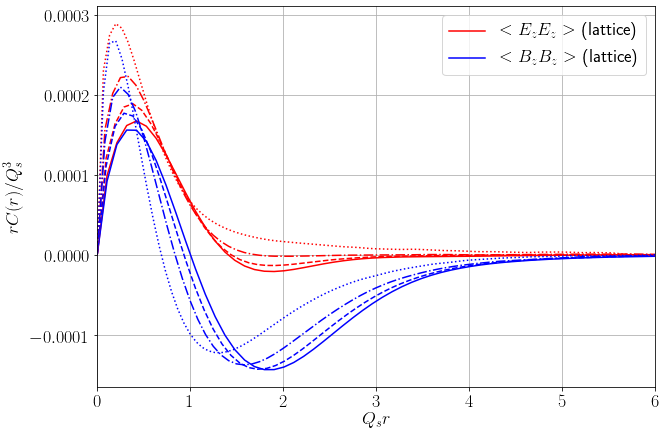

In [16]:
coordinate_data = []

Qs_ratios = [1.08, 0.98, 0.85, 0.68]
formats = ['-', '--', '-.', ':']
for i, res in enumerate(results):
    mu = g2mu / g ** 2
    m = m_ratios[i] * g2mu
    L = 100.0 / g2mu
    Qs = Qs_ratios[i] * g2mu
    
    r = np.linspace(0, L/2, num=N//2) 
    r *= Qs
    
    E0 = N / L * hbarc
    Ezs, Bzs = res["Ez"], res["Bz"]
    
    f = E0 ** 4 / g ** 2 / Qs ** 4
    m = m_ratios[i]
    Ez_d = r * f * Ezs
    Bz_d = r * f * Bzs
    
    coordinate_data.append(r)
    coordinate_data.append(Ez_d)
    coordinate_data.append(Bz_d)
    
    plt.plot(r, Ez_d, formats[i], c='r')
    plt.plot(r, Bz_d, formats[i], c='b')

plt.xlim([0, 6.0])
plt.grid()
plt.xlabel("$Q_s r$")
plt.ylabel("$r C(r) / Q^3_s$")
plt.legend(["$<E_z E_z>$ (lattice)", "$<B_z B_z>$ (lattice)"])
plt.show()

# export data for pgfplots
coordinate_data = np.array(coordinate_data).T
coordinate_data = np.nan_to_num(coordinate_data)

# reduce size of table for smaller plot file size
i1 = np.argmin(np.abs(coordinate_data[:, 0] - 6.5))
i2 = np.argmin(np.abs(coordinate_data[:, 3] - 6.5))
i3 = np.argmin(np.abs(coordinate_data[:, 6] - 6.5))
i4 = np.argmin(np.abs(coordinate_data[:, 9] - 6.5))

i_max = np.max([i1, i2, i3, i4])
coordinate_data = coordinate_data[:i_max, :]
np.savetxt("strong_correlators_r.dat", coordinate_data, header="Q_s r, r * <E_z E_z>, r * <B_z B_z> (x 4)")

# Momentum space correlators

Compute correlators in momentum space by performing the Hankel transformation.

In [7]:
from scipy.integrate import nquad, simps

# since numba does not support scipy.special out of the box, we have to do this:
from numba.extending import get_cython_function_address
from numba import vectorize, njit
import ctypes

# J(0,x)
addr = get_cython_function_address("scipy.special.cython_special", "j0")
functype = ctypes.CFUNCTYPE(ctypes.c_double, ctypes.c_double)
j0_fn = functype(addr)

@vectorize('float64(float64)')
def vec_j0(x):
    return j0_fn(x)

@njit
def j0_njit(x):
    return vec_j0(x)

# J(1, x)
addr = get_cython_function_address("scipy.special.cython_special", "j1")
functype = ctypes.CFUNCTYPE(ctypes.c_double, ctypes.c_double)
j1_fn = functype(addr)

@vectorize('float64(float64)')
def vec_j1(x):
    return j1_fn(x)

@njit
def j1_njit(x):
    return vec_j1(x)

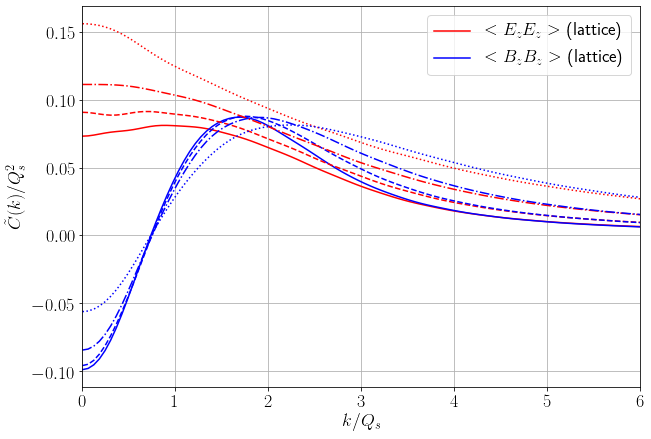

In [17]:
# Restrict the coordinate range used in the Hankel transformation to smooth out noise.
lim = 8.0
Qs_ratios = [1.08, 0.98, 0.85, 0.68]
momentum_data = []

formats = ['-', '--', '-.', ':']
for i, res in enumerate(results):
    mu = g2mu / g ** 2
    m = m_ratios[param_set] * g2mu
    L = 100.0 / g2mu
    Qs = Qs_ratios[i] * g2mu
    E0 = N / L
    
    f = E0 ** 4 / g ** 2 / Qs ** 4

    lim_L = L / lim
    lim_N = int(N / lim)

    r = np.linspace(0, lim_L, num=lim_N) # in (g^2 \mu)^{-1}
    r *= Qs                              # in (Qs)^{-1}
    
    Ezs, Bzs = res["Ez"], res["Bz"]
    Ez_d = r * f * Ezs[:lim_N]
    Bz_d = r * f * Bzs[:lim_N]
    
    p_range = np.linspace(0.0, 6.0, num=100)
    Ez_m = np.array([simps(x=r, y=Ez_d * vec_j0(p * r)) for p in p_range])
    Bz_m = np.array([simps(x=r, y=Bz_d * vec_j0(p * r)) for p in p_range])
    
    momentum_data.append(p_range)
    momentum_data.append(Ez_m)
    momentum_data.append(Bz_m)
    
    plt.plot(p_range, Ez_m, formats[i], c='r')
    plt.plot(p_range, Bz_m, formats[i], c='b')
plt.xlim([0, 6])
plt.xlabel("$k / Q_s$")
plt.ylabel("$\\tilde{C}(k) / Q^2_s$")
plt.legend(["$<E_z E_z>$ (lattice)", "$<B_z B_z>$ (lattice)"])
plt.grid()
plt.show()

momentum_data = np.array(momentum_data)


# export data for pgfplots
momentum_data = np.array(momentum_data).T
momentum_data = np.nan_to_num(momentum_data)
np.savetxt("strong_correlators_k.dat", momentum_data, header="k / Q_s, <E_z E_z>, <B_z B_z> (x 4)")